In [1]:
import gzip
try: import simplejson as json
except ImportError: import json

import codecs
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def parse(filename):
  #f = gzip.open(filename, 'r')
  f = codecs.open(filename,encoding='latin-1')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

In [3]:
finefood_data = []
for e in parse("finefoods.txt"):
    finefood_data.append(e)

In [4]:
print("Number of Amazon finefood reviews: {}".format(len(finefood_data)))

Number of Amazon finefood reviews: 568462


In [5]:
finefood_data[2]

{'product/productId': 'B000LQOCH0',
 'review/helpfulness': '1/1',
 'review/profileName': 'Natalia Corres "Natalia Corres"',
 'review/score': '4.0',
 'review/summary': '"Delight" says it all',
 'review/text': 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.',
 'review/time': '1219017600',
 'review/userId': 'ABXLMWJIXXAIN'}

In [6]:
#construct the reduced file with only productid, userid, rating
keep_property_arr =["product/productId", "review/userId", "review/score","review/time"]

In [7]:
finefood_reduced =[]
finefood_missingproperties = []
i=0
for review in finefood_data:
    user_jsobobj = dict()
    flag=0
    for prop in keep_property_arr:
        if prop not in review:
            finefood_missingproperties.append(review)
            flag=1
            break
    if flag==0:
        for property in keep_property_arr:
            if property =="review/score":
                user_jsobobj[property] = float(review[property])
            else:
                user_jsobobj[property] = review[property]
        finefood_reduced.append(user_jsobobj)

In [8]:
finefood_data[94197]

{'product/productId': 'B002RIZUQ2',
 'review/profileName': 'MABEL "Tell us about yourself!',
 'review/userId': 'AS2DLXUWDK0GP'}

In [9]:
print("Number of 'clean' reviews: {}".format(len(finefood_reduced)))
print("Number of reviews with incomplete information: {}".format(len(finefood_missingproperties)))

Number of 'clean' reviews: 568447
Number of reviews with incomplete information: 15


In [38]:
Iu = dict() #set of products reviewed by users
qualified_review_count = 0
userproduct_dict = dict()  #dictionary to find out review for particular user and item
train_data = []  #generate the qualified reviews
dup_ui_comb = []
ui_timestamp = dict()
count=0

mul_data = []

for review in finefood_reduced:
        item = review["product/productId"]
        user = review["review/userId"]
        time = review["review/time"]
        if user in Iu and item in Iu[user]:
            if [user,item] not in dup_ui_comb:
                dup_ui_comb.append([user,item])
            continue;
        if user in Iu:# and item not in Iu[user]:
            Iu[user].append(item)
            ui_timestamp["user"+"item"] = time;
        else:
            Iu[user] = [item]
            ui_timestamp["user"+"item"] = time;
        
        key = user+'-'+item
        userproduct_dict[key]  = review
        train_data.append(review)
        qualified_review_count+=1

In [11]:
# Dump all clean and unclean contents to separate files. These files are used for all further processing

In [39]:
print(qualified_review_count)

560797


In [42]:
print(len(dup_ui_comb))

5859


In [50]:
red_data = [] 
i=0
for user,item in dup_ui_comb:
    for review in finefood_reduced:
        if review["review/userId"] == user and review["product/productId"] == item:
            red_data.append(review)
    i+=1
    if i==50: 
        break

In [52]:
two_data= []
for review in finefood_data:
    try:
        if review["review/userId"] == "A1CBNUBPZPWH5D" and review["product/productId"] == "B0016FY6H6":
            two_data.append(review)
    except Exception:
        pass

In [53]:
two_data

[{'product/productId': 'B0016FY6H6',
  'review/helpfulness': '8/9',
  'review/profileName': 'Boston Lesbian "Happily Married in Massachusetts"',
  'review/score': '5.0',
  'review/summary': 'Flavorful and refreshing',
  'review/text': "I ordered this item because it was on sale and because of the health benefits of green tea.  I wasn't certain how good it was going to be but I was pleasantly surprised.  It tastes refreshing and fruity.  The flavor isn't overpowering or fake.  I mix the powder in a sports bottle along with cold water and splenda.  The powder dissolves easily and the drink has a nice green tea and blueberry taste.  I was so impressed that I have signed up for automatic delivery.  It's a great product.",
  'review/time': '1216339200',
  'review/userId': 'A1CBNUBPZPWH5D'},
 {'product/productId': 'B0016FY6H6',
  'review/helpfulness': '1/1',
  'review/profileName': 'Boston Lesbian "Happily Married in Massachusetts"',
  'review/score': '5.0',
  'review/summary': 'Nice Green I

In [12]:
with open("finefood_incompletedata.json",'w') as outfile:
    for line in finefood_missingproperties:
        json.dump(line,outfile)
        outfile.write("\n")
print("File {} written".format("finefood_incompletedata.json"))
outfile.close()

File finefood_incompletedata.json written


In [12]:
with open("finefood_reduced_time_data.json",'w') as outfile:
    json.dump(finefood_reduced,outfile)
print("File {} written".format("finefood_reduced_time_data.json"))
outfile.close()

File finefood_reduced_time_data.json written


## Exploratory analysis

In [103]:
user_set = set()
product_set = set()

In [105]:
scores =[]

In [108]:
for review in finefood_reduced:
    if review["product/productId"] not in product_set:
        product_set.add(review["product/productId"])
    if review["review/userId"] not in user_set:
        user_set.add(review["review/userId"])
    scores.append(review["review/score"])

In [109]:
print("Number of products: {}".format(len(product_set)))
print("Number of users: {}".format(len(user_set)))

Number of products: 74257
Number of users: 256055


In [116]:
distinct_scores = dict()
for score in scores:
    if score not in distinct_scores:
        distinct_scores[score]=1
    else:
        distinct_scores[score]+=1

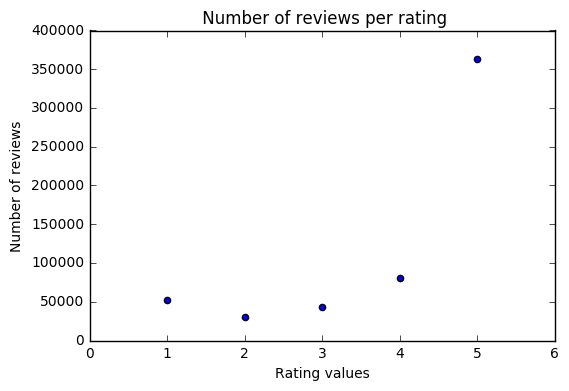

In [133]:
plt.scatter(list(distinct_scores.keys()),list(distinct_scores.values()))
plt.xlabel("Rating values")
plt.ylabel("Number of reviews")
plt.title(" Number of reviews per rating")
plt.show()

In [243]:
#figure out distribution of average rating of products / or ratings given by users
Iu = dict()
Ui = dict()

In [244]:
for review in finefood_reduced:
    if review["product/productId"] in Ui:
        Ui[review["product/productId"]].append(float(review["review/score"]))
    else:
        Ui[review["product/productId"]] = [float(review["review/score"])]
    if review["review/userId"] in Iu:
        Iu[review["review/userId"]].append(float(review["review/score"]))
    else:
        Iu[review["review/userId"]] = [float(review["review/score"])]

In [245]:
Iu_len = dict()
len_user = []
for key in Iu:
    if len(Iu[key]) not in Iu_len:
        Iu_len[len(Iu[key])]=1
    else:
        Iu_len[len(Iu[key])]+=1
    len_user.append(len(Iu[key]))

In [246]:
len_user.sort()

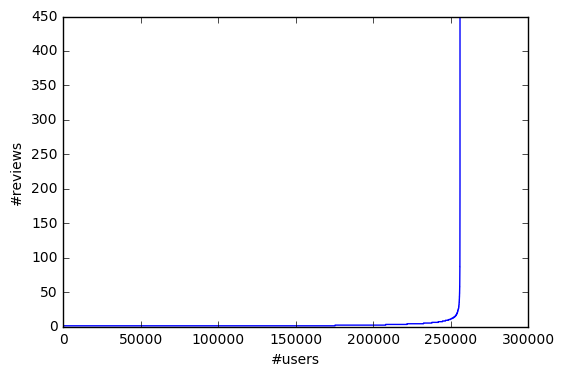

In [247]:
plt.plot(len_user)
plt.xlabel("#users")
plt.ylabel("#reviews")
plt.show()

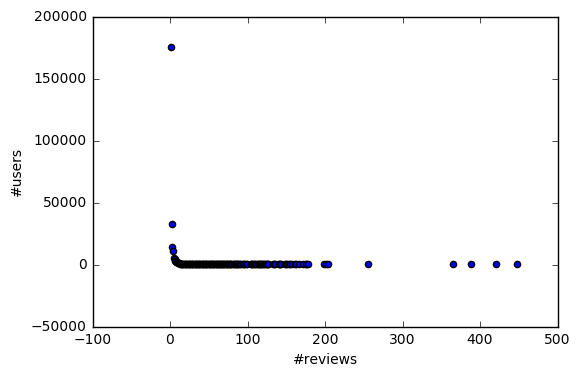

In [248]:
plt.scatter(list(Iu_len.keys()),list(Iu_len.values()))
plt.ylabel("#users")
plt.xlabel("#reviews")
plt.show()

In [249]:
review_cutoff = 10

In [250]:
count = 0
for key in Iu_len:
    if key>review_cutoff:
        count+= Iu_len[key]
        

In [251]:
print("Number of users who have written more than {} reviews is {}".format(review_cutoff,count))

Number of users who have written more than 10 reviews is 6359


In [274]:
avg_user_rating = dict()
for key in Iu:
    if np.mean(Iu[key]) not in avg_user_rating:
        avg_user_rating[np.mean(Iu[key])]=1
    else:
        avg_user_rating[np.mean(Iu[key])]+=1

In [285]:
x = sorted(list(avg_user_rating.keys()),reverse=True)

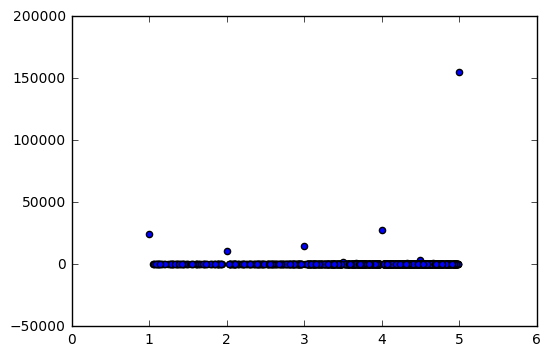

In [289]:
plt.scatter(list(avg_user_rating.keys()), list(avg_user_rating.values()))
plt.show()